# Personalized Real Estate Agent

**This notebook:**

- Generates synthetic real estate listings using an LLM
- Stores listings in a ChromaDB vector database
- Collects buyer preferences
- Retrieves the most relevant listings using semantic search
- Multimodal search and ranking with CLIP
- Personalizes listings based on buyer preferences

## Introduction

Imagine you're a talented developer at "Future Homes Realty," a forward-thinking real estate company. In an industry where personalization is key to customer satisfaction, your company wants to revolutionize how clients interact with real estate listings. The goal is to create a personalized experience for each buyer, making the property search process more engaging and tailored to individual preferences.

## The Challenge

Your task is to develop an innovative application named "HomeMatch." This application leverages **large language models** (LLMs) and **vector databases** to *transform* standard real estate listings into *personalized narratives* that resonate with potential buyers' unique preferences and needs.

### Core Components of "HomeMatch"

- **Understanding buyer preferences:** Buyers will input their requirements and preferences, such as location, property type, budget, amenities, and lifestyle choices. The application uses LLMs to interpret these inputs in natural language, understanding nuanced requests beyond basic filters.
- **Integrating with a vector database:** Connect "HomeMatch" with a vector database, where all available property listings are stored. Utilize vector embeddings to match properties with buyer preferences, focusing on aspects like neighborhood vibes, architectural styles, and proximity to specific amenities.
- **Personalized listing description generation:** For each matched listing, use an LLM to rewrite the description in a way that highlights aspects most relevant to the buyer’s preferences. Ensure personalization emphasizes characteristics appealing to the buyer without altering factual information about the property.
- **Listing presentation:** Output the personalized listing(s) as a text description of the listing.

In [1]:
import os
from typing import Dict, List

import clip
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema import Document
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate

In [2]:
# Set API key for OpenAI
os.environ["OPENAI_API_KEY"] = "voc-25036804512667737229546772e527771fe5.81392341"
os.environ["OPENAI_API_BASE"] = "https://openai.vocareum.com/v1"

In [3]:
# Initialize LLM
llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",
    temperature=0.7
)

embeddings = OpenAIEmbeddings()

In [4]:
# Load CLIP model for image embeddings
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", jit=False, device=device)

## Generating Real Estate Listings

Generating at least 10 synthetic real estate listings using an LLM. This can involve creating prompts for the LLM to produce descriptions of various properties. Afterwards, using these listings to populate the database for testing and development of "HomeMatch."

In [5]:
def generate_listings(n: int = 10) -> List[str]:
    """
    Generate a specified number of diverse real estate listings.

    This function uses a language model to generate listings that include 
    neighborhood, price, number of bedrooms, bathrooms, size, and description.

    Args:
        n (int): The number of listings to generate. Defaults to 10.

    Returns:
        List[str]: A list containing the generated real estate listings as strings.
    """
    # Construct the prompt for the language model
    prompt = f"""
        Generate {n} diverse real estate listings with neighborhood,
        price, bedrooms, bathrooms, size, and description.
    """
    
    # Invoke the language model with the constructed prompt
    response = llm.invoke(prompt)
    
    # Split the response into individual listings and return as a list
    return response.content.split("\n\n")


listings = generate_listings()
print(listings[0])

1. Neighborhood: Upper East Side, Manhattan, New York
   Price: $2,500,000
   Bedrooms: 3
   Bathrooms: 2
   Size: 1,800 sqft
   Description: Luxury penthouse with stunning views of Central Park, high-end finishes, and top-of-the-line appliances.


In [6]:
# Save listings to a text file
with open("listings.txt", "w") as f:
    for listing in listings:
        f.write(listing + "\n\n")

## Storing Listings in a Vector Database

1. **Vector Database Setup**

    Initializing and configuring *ChromaDB* to store real estate listings.

2. **Generating and Storing Embeddings**

    Converting the LLM-generated listings into suitable embeddings that capture the semantic content of each listing, and storing these embeddings in the vector database.

In [7]:
# Store listings in a vector database
docs = [
    Document(page_content=listing)
    for listing in listings
]

db = Chroma.from_documents(docs, embeddings)

## Building the User Preference Interface

Collecting buyer preferences, such as the number of bedrooms, bathrooms, location, and other specific requirements from a set of questions or telling the buyer to enter their preferences in natural language.

In [8]:
# Collect buyer preferences
questions = [   
    "How big do you want your house to be?",  
    "What are 3 most important things for you in choosing this property?",  
    "Which amenities would you like?",  
    "Which transportation options are important to you?",  
    "How urban do you want your neighborhood to be?"   
]

answers = [
    "A comfortable three-bedroom house with a spacious kitchen and a cozy living room.",
    "A quiet neighborhood, good local schools, and convenient shopping options.",
    "A backyard for gardening, a two-car garage, and a modern, energy-efficient heating system.",
    "Easy access to a reliable bus line, proximity to a major highway, and bike-friendly roads.",
    "A balance between suburban tranquility and access to urban amenities like restaurants and theaters."
]

buyer_preferences = " ".join(answers)

## Searching Based on Preferences

1. **Semantic Search Implementation**

   Using the structured buyer preferences to perform a semantic search on the vector database, retrieving listings that most closely match the user's requirements.

2. **Listing Retrieval Logic**

   Fine-tuning the retrieval algorithm to ensure that the most relevant listings are selected based on the semantic closeness to the buyer’s preferences.

In [9]:
# Search based on preferences (text)
retriever = db.as_retriever()
retrieved_docs = retriever.get_relevant_documents(buyer_preferences)

The `text_embedding` has a shape of `(1536,)`, while the `image_embeddings` are `(1, 512)`. These dimensions must be aligned for a valid comparison. We need to ensure both embeddings are in the same dimensional space. Since CLIP produces 512-dimensional embeddings and OpenAI's embedding model produces 1536-dimensional embeddings, we need a transformation step.

Possible solutions are:

1. Reducing the text embedding dimension to 512
    - Using a dimensionality reduction technique like **PCA** or **UMAP** to map the text embedding into the 512-dimensional space of the image embeddings.
2. Expanding the image embeddings to 1536
    - Using zero-padding or a neural network projection layer to map the 512-dimensional image embeddings to 1536 dimensions.
3. Using CLIP for text embedding too
    - Instead of OpenAI embeddings, using CLIP’s `encode_text` method to generate text embeddings, ensuring both text and image embeddings have the same dimensionality.

To implement option 3, where CLIP is used for both text and image embeddings, we need to modify the text embedding extraction process. We use the `encode_text` method of CLIP to generate embeddings for the buyer preferences, ensuring both text and image embeddings have the same dimensionality (512 dimensions).

In [10]:
def get_text_embedding(text: str) -> np.ndarray:
    """
    Extracts a text embedding from the given text using CLIP's encode_text method.

    Args:
        text (str): The text for which to generate an embedding.

    Returns:
        np.ndarray: The combined embedding of the text, averaged over all chunks.
    """
    # Split text into smaller chunks
    # CLIP's tokenize method has a maximum context length of 77 characters
    # We split the text into chunks of max 77 characters to avoid exceeding this limit
    text_chunks = [text[i:i+77] for i in range(0, len(text), 77)]
    embeddings = []
    
    # Iterate over each chunk and generate its embedding
    for chunk in text_chunks:
        # Tokenize the chunk
        text_input = clip.tokenize([chunk]).to(device)
        
        # Get the embedding of the chunk
        with torch.no_grad():
            chunk_embedding = clip_model.encode_text(text_input).cpu().numpy()
        
        # Store the embedding
        embeddings.append(chunk_embedding)
    
    # Combine embeddings (mean of all chunks)
    # We take the mean of the embeddings to get a single embedding for the entire text
    combined_embedding = np.mean(embeddings, axis=0)
    
    return combined_embedding

The `get_text_embedding` function uses CLIP's `encode_text` method to create the text embedding for the buyer preferences. Both text and image embeddings are now produced using CLIP, ensuring they have matching dimensions.

Furthermore, the `text` is split into chunks of 77 characters (or fewer, if the chunk length is smaller than 77). CLIP can handle each chunk, and this prevents the model from receiving too much input at once. Since CLIP's tokenizer has a maximum context length (77 tokens), and splitting the input into smaller chunks ensures that the text stays within this limit.

After embedding each chunk, we combine the embeddings by taking their mean. This way, we get a unified text embedding that represents the entire input. In other words, by averaging the embeddings of all chunks, we preserve the overall meaning of the input while ensuring compatibility with CLIP.

In [11]:
# Get text embedding for the buyer preferences
text_embedding = get_text_embedding(buyer_preferences)

In [12]:
def get_image_embedding(image_path: str) -> np.ndarray:
    """
    Extracts an image embedding using CLIP's encode_image method.

    Args:
        image_path (str): The path to the image file.

    Returns:
        np.ndarray: The embedding of the image.
    """
    # Preprocess the image and move to the appropriate device
    # The preprocess method is from the CLIP library
    # It resizes the image to 224x224 and normalizes it
    # We then move the image to the same device as the CLIP model
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    
    # Get the embedding of the image without computing gradients
    # We use torch.no_grad() to prevent gradient computation
    # This is because we are only using the CLIP model for inference
    # and we don't need to compute gradients for the training step
    with torch.no_grad():
        image_embedding = clip_model.encode_image(image).cpu().numpy()
    
    return image_embedding

In [13]:
# Load image embeddings
image_embeddings = {}

# Real estate-related images that align with the property descriptions
directory = "imgs/"
image_paths = os.listdir(directory)

for path in image_paths:
    image_embeddings[path] = get_image_embedding(os.path.join(directory, path))

In [14]:
# Debugging to check embeddings shape
print(f"Text embedding shape: {text_embedding.shape}")

for embedding in image_embeddings.values():
    print(f"Image embedding shape: {embedding.shape}")
    break

Text embedding shape: (1, 512)
Image embedding shape: (1, 512)


The `multimodal_ranking` function compares the 512-dimensional embeddings of both text and images, ensuring they can be compared directly. Multimodal ranking is performed by comparing these embeddings using the **Euclidean distance** (`np.linalg.norm`).

In [15]:
def multimodal_ranking(
    text_embedding: np.ndarray,
    image_embeddings: Dict[str, np.ndarray]
) -> List[str]:
    """
    Perform multimodal ranking by comparing the 512-dimensional embeddings of both text and images,
    ensuring they can be compared directly. Multimodal ranking is performed by comparing these embeddings
    using the Euclidean distance (np.linalg.norm).

    Args:
        text_embedding: The 512-dimensional embedding of the text to compare against.
        image_embeddings: A dictionary of image paths to 512-dimensional image embeddings.
            The dictionary keys are the image paths, and the dictionary values are the image embeddings.

    Returns:
        A list of image paths ranked by similarity to the text embedding.
    """
    # Sort the image embeddings by their Euclidean distance to the text embedding
    ranked_results = sorted(
        image_embeddings.items(),
        key=lambda x: np.linalg.norm(text_embedding - x[1])
    )
    
    # Return a list of just the image paths in the ranked order
    return [item[0] for item in ranked_results]

Integrating image embeddings into the multimodal search by ranking images based on *similarity* to buyer preferences.

In [16]:
# Perform multimodal ranking
ranked_images = multimodal_ranking(text_embedding, image_embeddings)

## Personalizing Listing Descriptions

1. **LLM Augmentation**

    For each retrieved listing, using the LLM to augment the description, tailoring it to resonate with the buyer’s specific preferences. This involves subtly emphasizing aspects of the property that align with what the buyer is looking for.

2. **Maintaining Factual Integrity**

    Ensuring that the augmentation process enhances the appeal of the listing without altering factual information.

In [17]:
# Personalize listing descriptions
prompt_template = PromptTemplate(
    input_variables=["listing", "preferences"],
    template="Given the listing: {listing}, personalize it for a buyer with preferences: {preferences}"
)

## Deliverables and Testing

Testing the "HomeMatch" application and making sure it meets all of the requirements in the project rubric. Entering different "buyer preferences" and ensuring it works.

In [18]:
personalized_listings = [
    llm.invoke(prompt_template.format(
        listing=doc.page_content,
        preferences=buyer_preferences
    )).content
    for doc in retrieved_docs
]

In [19]:
# Output results
for i, listing in enumerate(personalized_listings):
    print(f"Personalized Listing {i+1}:\n\n{listing}\n\n\n")

Personalized Listing 1:

Seeking a charming three-bedroom home in the quiet neighborhood of Old Town, Chicago? Look no further than this historic brownstone townhouse with original details and exposed brick. With a spacious kitchen and cozy living room, this 1,200 sqft home offers the perfect blend of suburban tranquility and urban convenience. Enjoy a private backyard for gardening, a two-car garage, and modern, energy-efficient heating system. Conveniently located near good local schools, shopping options, and easy access to public transportation and major highways. Don't miss the opportunity to make this house your dream home! Listed at $600,000.



Personalized Listing 2:

This cozy three-bedroom house in The Woodlands neighborhood of Houston, Texas is perfect for a buyer seeking comfort and convenience. The spacious kitchen is ideal for cooking and entertaining, while the cozy living room is perfect for relaxing with family and friends. The quiet neighborhood boasts good local sch

In [20]:
def plot_ranked_images(ranked_images: List[str], directory: str) -> None:
    """
    This function takes the list of ranked image paths and the directory containing
    the images, and displays them in a row. Each image is displayed in a separate
    subplot, with its title set to the image path.

    Args:
        ranked_images (List[str]): List of ranked image paths.
        directory (str): Directory containing the images.
    """
    print("Displaying ranked images based on preferences:\n")
    
    # Create a subplot with as many columns as there are images
    fig, axes = plt.subplots(1, len(ranked_images), figsize=(15, 5))
    
    for idx, img_path in enumerate(ranked_images):
        try:
            # Open the image
            img = Image.open(os.path.join(directory, img_path))
            
            # Display the image in the corresponding subplot
            axes[idx].imshow(img)
            axes[idx].set_title(img_path, fontsize=9)
            axes[idx].axis('off')
        except Exception as e:
            print(f"Could not display image {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()

Displaying ranked images based on preferences:



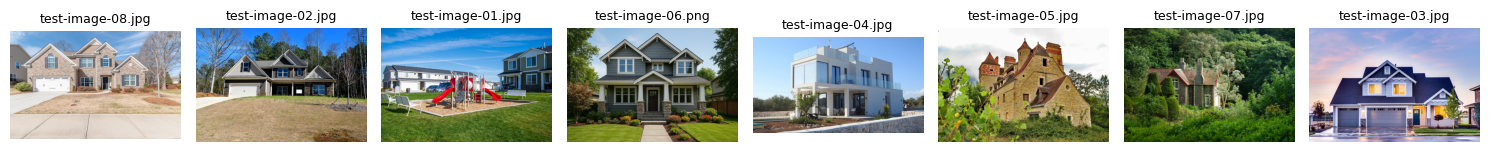

In [21]:
# Output the ranked images as visualizations
plot_ranked_images(ranked_images, directory)